# Measurement Calibration: Bridging Simulation and Fabrication

> Our robust adjoint design is ready for fabrication, but once real devices come back from the foundry, their spectral responses rarely match the nominal simulation exactly. In this notebook we demonstrate a way to calibrate the simulation model to match measured data using adjoint optimization, recovering the as-built geometry so subsequent optimization or analysis stays grounded in reality.

Just as we used gradient-based optimization with adjoint derivatives to design the device, we can apply the same approach to calibrate fabrication parameters. Instead of optimizing geometric features to achieve a target performance, we now optimize fabrication corners (like width bias, etch depth, or sidewall angle) to match measured spectral data. Because we're using adjoint sensitivities, this approach scales efficiently to many parameters - real-world calibration often involves multiple fabrication variables simultaneously, and adjoint lets us handle that complexity with the same computational efficiency we saw during design.

In [ ]:
import json
from copy import deepcopy
from pathlib import Path

import autograd.numpy as np
import matplotlib.pyplot as plt
import numpy as npl
import tidy3d as td
from autograd import value_and_grad
from optim import adam_update, apply_updates, clip_params, init_adam
from setup import get_mode_monitor_power, make_simulation, widths_gaps_to_centers
from tidy3d import web

## Calibration Workflow Overview

We assume access to three ingredients:
1. The robust nominal design.
2. A measured spectrum from fabricated hardware (here we synthesize one by applying a known bias and measurement noise).
3. A differentiable simulation model we can tune so the simulated spectrum matches the measured data.

The goal is to infer the effective SiN tooth widths that best reproduce the measurement, keeping the digital twin aligned with the hardware. We'll use gradient-based optimization driven by adjoint sensitivities - the same computational engine that powered our design optimization - to efficiently tune the fabrication parameters.

In [2]:
def centers_widths_to_spacing(centers, widths, *, last_gap):
    """Return (first_gap, gaps) that preserve the supplied centers."""
    centers = np.array(centers)
    widths = np.array(widths)
    if widths.size == 0:
        return 0.0, np.zeros_like(widths)
    left_edges = centers - widths / 2
    right_edges = centers + widths / 2
    first_gap = left_edges[0]
    if widths.size == 1:
        gaps = np.array([last_gap], dtype=widths.dtype)
    else:
        interior = left_edges[1:] - right_edges[:-1]
        gaps = np.concatenate((interior, np.array([last_gap], dtype=widths.dtype)))
    return first_gap, gaps


def extract_spectrum(sim_data):
    """Return (freqs, power) from the mode monitor of `sim_data`."""
    power_da = get_mode_monitor_power(sim_data)
    freqs = power_da.coords["f"].values
    power = np.array(power_da.data).squeeze()
    return freqs, power


def to_wavelength_db(freqs, power):
    """Convert a spectrum to (wavelength, power_db) sorted by wavelength."""
    wavelengths = td.C_0 / freqs
    order = np.argsort(wavelengths)
    wl = wavelengths[order]
    power_lin = np.array(power)[order]
    power_db = 10 * np.log10(np.clip(power_lin, 1e-12, None))
    return wl, power_db

## Generating Reference and Synthetic Measurement Data

The baseline spectrum corresponds to the calibrated simulation before any fabrication shifts. To emulate a measured device we create a second spectrum with a uniform +20 nm SiN width bias and add multiplicative noise, representing typical measurement variability.

In [3]:
rng = npl.random.default_rng(1234)

robust_path = Path("./results") / "gc_adjoint_robust_best.json"

robust_data = json.loads(robust_path.read_text(encoding="utf-8"))
widths_si_nominal = np.array(robust_data["widths_si"], dtype=float)
gaps_si_nominal = np.array(robust_data["gaps_si"], dtype=float)
widths_sin_nominal = np.array(robust_data["widths_sin"], dtype=float)
gaps_sin_nominal = np.array(robust_data["gaps_sin"], dtype=float)
first_gap_si_nominal = float(robust_data["first_gap_si"])
first_gap_sin_nominal = float(robust_data["first_gap_sin"])

sin_centers, _ = widths_gaps_to_centers(
    widths_sin_nominal, gaps_sin_nominal, first_gap=first_gap_sin_nominal
)
sin_last_gap_template = gaps_sin_nominal[-1]

In [4]:
# Baseline spectrum from the robust design provides the "uncalibrated" reference.
baseline_sim = make_simulation(
    widths_si_nominal,
    gaps_si_nominal,
    widths_sin_nominal,
    gaps_sin_nominal,
    first_gap_si=first_gap_si_nominal,
    first_gap_sin=first_gap_sin_nominal,
)
baseline_data = web.run(baseline_sim, task_name="gc_measurement_baseline", verbose=False)
base_freqs, base_power = extract_spectrum(baseline_data)

In [5]:
# Synthetic measurement: apply a uniform width bias to the SiN layer.
global_bias = 0.02
biased_widths_sin = widths_sin_nominal + global_bias
biased_first_gap_sin, biased_gaps_sin = centers_widths_to_spacing(
    sin_centers, biased_widths_sin, last_gap=sin_last_gap_template
)

measurement_sim = make_simulation(
    widths_si_nominal,
    gaps_si_nominal,
    biased_widths_sin,
    biased_gaps_sin,
    first_gap_si=first_gap_si_nominal,
    first_gap_sin=biased_first_gap_sin,
)
measurement_data = web.run(measurement_sim, task_name="gc_measurement_truth", verbose=False)
meas_freqs, meas_power = extract_spectrum(measurement_data)

In [6]:
tooth_indices = npl.arange(1, biased_widths_sin.size + 1)

noise_sigma = 0.01
noise = rng.normal(scale=noise_sigma, size=meas_power.shape)
noisy_power = np.clip(meas_power * (1.0 + noise), 1e-12, None)

target_power = np.array(noisy_power, dtype=float)

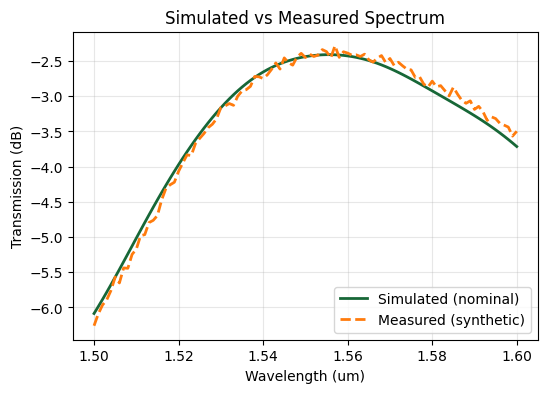

In [7]:
wl_base, base_db = to_wavelength_db(base_freqs, base_power)
wl_meas, meas_db = to_wavelength_db(meas_freqs, noisy_power)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(wl_base, base_db, label="Simulated (nominal)", linewidth=2)
ax.plot(
    wl_meas,
    meas_db,
    label="Measured (synthetic)",
    linewidth=2,
    linestyle="--",
)
ax.set_xlabel("Wavelength (um)")
ax.set_ylabel("Transmission (dB)")
ax.set_title("Simulated vs Measured Spectrum")
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

## Calibration Objective

We adjust the SiN tooth widths so the simulated spectrum matches the measured one. The loss is the mean-squared error between spectra sampled at the monitor frequencies, optimized with Adam while respecting fabrication bounds.

In this example we optimize a single global width bias, which is a one-dimensional problem that could also be solved with simpler techniques like bisection or line search. However, we're showcasing adjoint optimization here because real calibration scenarios often involve multiple correlated fabrication parameters (width bias, etch depth, sidewall angle, material index shifts, etc.) and adjoint derivatives make it practical to optimize all of them simultaneously. This demonstration establishes the workflow that scales naturally to those multi-parameter calibration problems.

In [8]:
def objective(params):
    bias = params["bias"]
    widths_sin = widths_sin_nominal + bias
    first_gap_sin, gaps_sin = centers_widths_to_spacing(
        sin_centers, widths_sin, last_gap=sin_last_gap_template
    )
    sim = make_simulation(
        widths_si_nominal,
        gaps_si_nominal,
        widths_sin,
        gaps_sin,
        first_gap_si=first_gap_si_nominal,
        first_gap_sin=first_gap_sin,
    )
    sim_data = web.run(sim, task_name="gc_measurement_calibration_opt", verbose=False)
    power_da = get_mode_monitor_power(sim_data)
    power = np.array(power_da.data).squeeze()
    diff = power - target_power
    return np.mean(diff**2)

In [9]:
params0 = {"bias": 0.0}
bounds = {"bias": (-0.05, 0.05)}

vg_fun = value_and_grad(objective)
params = deepcopy(params0)
opt_state = init_adam(params, lr=2e-3)

mse_history = []
bias_history = []
best_value = float("inf")
best_params = deepcopy(params)
num_iters = 12
for n in range(num_iters):
    value, grad = vg_fun(params)
    value_float = float(value)
    mse_history.append(value_float)
    bias_history.append(float(params["bias"]))
    print(f"iter {n}: mse={value_float:.6e}, bias={float(params['bias']):.6f}")

    if value_float < best_value:
        best_value = value_float
        best_params = deepcopy(params)

    updates, opt_state = adam_update(grad, opt_state)
    params = apply_updates(params, updates)
    params = clip_params(params, bounds)

iter 0: mse=1.168650e-04, bias=0.000000
iter 1: mse=9.655110e-05, bias=0.002000
iter 2: mse=8.147495e-05, bias=0.003991
iter 3: mse=6.712432e-05, bias=0.005965
iter 4: mse=5.820263e-05, bias=0.007910
iter 5: mse=4.864759e-05, bias=0.009820
iter 6: mse=4.191141e-05, bias=0.011675
iter 7: mse=3.766940e-05, bias=0.013464
iter 8: mse=3.487550e-05, bias=0.015177
iter 9: mse=3.235886e-05, bias=0.016812
iter 10: mse=3.058458e-05, bias=0.018360
iter 11: mse=2.997697e-05, bias=0.019815


In [10]:
optimized_bias = best_params["bias"]
calibrated_widths_sin = widths_sin_nominal + optimized_bias
calibrated_first_gap_sin, calibrated_gaps_sin = centers_widths_to_spacing(
    sin_centers, calibrated_widths_sin, last_gap=sin_last_gap_template
)

calibrated_sim = make_simulation(
    widths_si_nominal,
    gaps_si_nominal,
    calibrated_widths_sin,
    calibrated_gaps_sin,
    first_gap_si=first_gap_si_nominal,
    first_gap_sin=calibrated_first_gap_sin,
)
calibrated_data = web.run(
    calibrated_sim, task_name="gc_measurement_calibration_final", verbose=False
)
calib_freqs, calib_power = extract_spectrum(calibrated_data)
wl_calib, calib_db = to_wavelength_db(calib_freqs, calib_power)

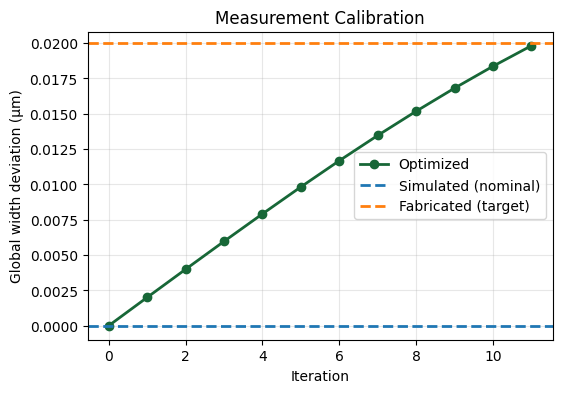

In [11]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(npl.arange(len(bias_history)), bias_history, marker="o", label="Optimized", linewidth=2)
ax.axhline(0.0, color="tab:blue", linestyle="--", linewidth=2, label="Simulated (nominal)")
ax.axhline(
    global_bias, color="tab:orange", linestyle="--", linewidth=2, label="Fabricated (target)"
)
ax.set_xlabel("Iteration")
ax.set_ylabel("Global width deviation (µm)")
ax.set_title("Measurement Calibration")
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

After optimization, the width deviation matches the "fabricated" one very well. Note that the match is not perfect, although the remaining discrepancy is due to the convergence properties of the optimizer - running more iterations would further reduce the error.

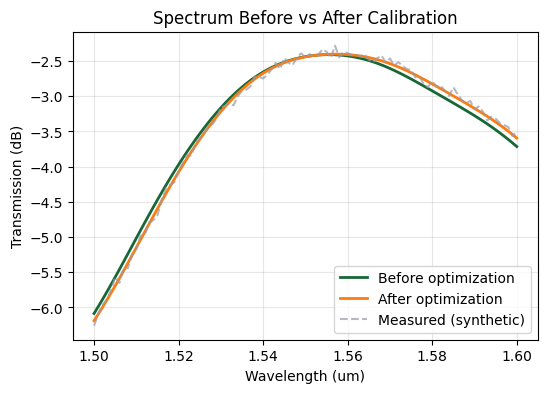

In [12]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(
    wl_base,
    base_db,
    label="Before optimization",
    linewidth=2,
)
ax.plot(
    wl_calib,
    calib_db,
    label="After optimization",
    linewidth=2,
)
ax.plot(
    wl_meas,
    meas_db,
    label="Measured (synthetic)",
    linewidth=1.5,
    linestyle="--",
    alpha=0.7,
)
ax.set_xlabel("Wavelength (um)")
ax.set_ylabel("Transmission (dB)")
ax.set_title("Spectrum Before vs After Calibration")
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

## Takeaways

By calibrating the simulation to match measurement we keep the model and fabricated hardware in sync. Combined with robust optimization this closes the loop between design, fabrication, and test, enabling faster debug and higher-yield deployment of inverse-designed photonics.

Key advantages of the gradient-based approach:
- **Scalability**: Adjoint derivatives allow efficient optimization of many fabrication parameters simultaneously (width bias, etch depth, sidewall angle, material variations, etc.) without a combinatorial explosion in computational cost.
- **Versatility**: The same optimization framework used for device design applies seamlessly to calibration, demonstrating the broad applicability of adjoint methods across the photonics workflow.
- **Precision**: Gradient information enables faster convergence to accurate parameter estimates compared to gradient-free methods, especially important when calibration involves expensive simulations.